# Part I - IN THEORY

## Problem 1. Discriminant Functions

In order to find and plot the discrimant functions for the Gaussians, we should first define a general discrimant function that computes the decision boundary given Gaussian statistics. We can then generate the boundaries by feeding necessary parameters. For this problem, we assume that the number of samples in each class is the same. That is, $N_{1}=N_{2}$, where $N_{i}$ represents the number of samples in class $i$. With this assumption, we can easily conclude that $logP(\omega_{1})=logP(\omega_{2})$, where $P(\omega_{i})$ is the probabiliy of class $\omega_{i}$. This will become useful when we compute the boundary function because the $P(\omega_{i})$ term can be canceled on both sides.

In [1]:
import matplotlib
import numpy as np
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import linalg as LA
from math import pi

In [2]:
# Given means and covariances of two Gaussian distributions, this class computes

class Gaussian_pairs(object):
    def __init__(self, mean1, cov1, mean2, cov2):
        self.means = [mean1, mean2]
        self.covs = [cov1, cov2]
        self.dim1 = [mean[0] for mean in [mean1, mean2]]
        self.dim2 = [mean[1] for mean in [mean1, mean2]]
        self.delta = 0.5
    
    # find the coordinate pairs, which are essentially data samples on which we want to find the probability that
    # they come from a particular Gaussian distribution
    def find_coord(self):
        x_min = min(self.dim1) - 15.0
        x_max = max(self.dim1) + 15.0
        y_min = min(self.dim2) - 15.0
        y_max = max(self.dim2) + 15.0
        x = np.arange(x_min, x_max, self.delta)
        y = np.arange(y_min, y_max, self.delta)
        self.X, self.Y = np.meshgrid(x, y)
        X_flat = self.X.flatten()
        Y_flat = self.Y.flatten()
        self.coord = np.stack((X_flat, Y_flat))

    # compute the Gaussian discriminant functions for both distributions
    def find_GDF(self):
        x_num = self.coord.shape[1]
        self.gdf = []
        for i in range(2):
            mean = self.means[i]
            cov = self.covs[i]
            w_mat = -1/2 * LA.inv(cov) # weight matrix
            w_vec = LA.inv(cov) @ mean # weight vector
            w_sca = -1/2 * mean.T @ LA.inv(cov) @ mean - 1/2 * np.log(LA.det(cov))
            gdf = np.diag(self.coord.T @ w_mat @ self.coord) + w_vec.T @ self.coord + w_sca * np.ones(x_num)
            self.gdf.append(gdf.reshape(self.X.shape))
    
    # plot the contour
    def plot_contour(self):
        diff = (self.gdf[1]-self.gdf[0])
        levels = [-7, -5, -3]
        fig, ax = plt.subplots(figsize=(5,5))
        cont1 = ax.contour(self.X, self.Y, self.gdf[0], levels=levels, colors='red')
        cont2 = ax.contour(self.X, self.Y, self.gdf[1], levels=levels, colors='blue')
        ax.contour(self.X, self.Y, diff, levels=[0], colors='black')
        lines = [cont1.collections[0], cont2.collections[0]]
        label1 = 'mean='+ str(self.means[0])+ ', covariance='+ str(self.covs[0][0]) + str(self.covs[0][1])
        label2 = 'mean='+ str(self.means[1])+ ', covariance='+ str(self.covs[1][0]) + str(self.covs[1][1])
        labels = [label1, label2]
        ax.set_title('contour for two Gaussians and their discriminant boundary')
        ax.legend(lines, labels)

In [3]:
# specify statistics for each Gaussian pairs
means1 = np.array([[0,0],[0,0],[0,0],[0,0]])
covs1 = np.array([[[1,0],[0,1]],[[1,0],[0,2]],[[1,0],[0,2]],[[1,0],[0,2]]])
means2 = np.array([[4,0],[4,3],[1/2,0],[4,0]])
covs2 = np.array([[[1,0],[0,1]],[[1,0],[0,1]],[[1,0],[0,1]],[[2,0],[0,1]]])

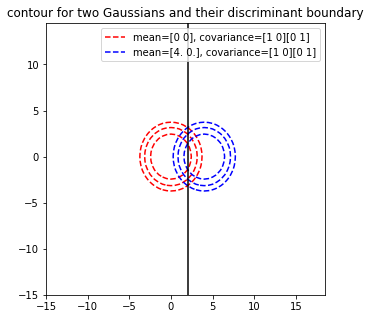

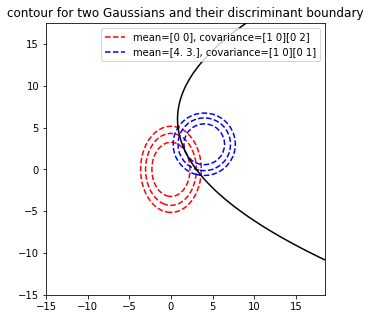

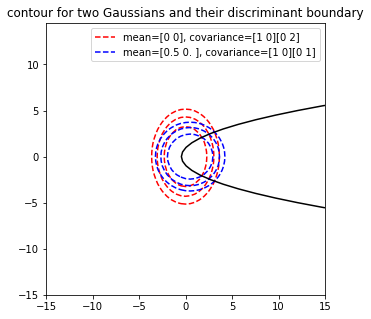

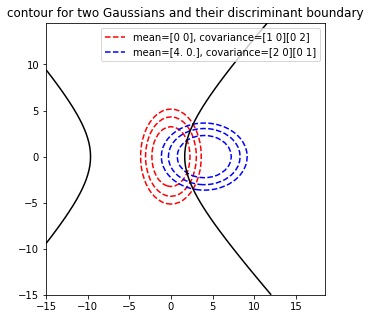

In [4]:
GP = []
for i in range(4):
    GP.append(Gaussian_pairs(means1[i], covs1[i], means2[i], covs2[i]))
    GP[i].find_coord()
    GP[i].find_GDF()
    GP[i].plot_contour()

As we can see from the contour and boundary plots, the shape of the contour precisely reflects the Gaussian distributions and gives us a very intuitive intepretation of the model. Specifically, the center of the contour ellipse is the mean of the Gaussian, while axes reflect the covariance along the correponding dimension. In some cases, the discriminant boundary is just one curve which divides the pairs into two areas. However, in some special case, there exist multiple boundaries. The forth pair is an example of the case: The two Gaussians are exactly orthogonal to each other, so the distributions appear to cross each other and make the discriminant function a hyperbola.

# Part II - IN PRACTICE
## Problem 2. Handwritten Digit Recognition
In this problem, we make the assumption that data of each digit belongs to different Gaussian distributions. We can thus find the mean and covariance for each digit and predict the digit by computing the probability of each Gaussian. It should be noted each image contains 28-by-28, or 784 pixels. For computational efficiency, we first apply PCA to each data and generate Gaussian classifiers on the low dimensional data.

In [5]:
# Code Reference: https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
# The code in this cell is slightly modified for the actual implementation

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#              rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [6]:
# define PCA
def pca(x, k):
    from scipy.sparse.linalg import eigsh
    xm = x - np.mean( x, axis=1, keepdims=True)
    C = xm.dot( xm.T) / (xm.shape[1]-1)
    v,u = eigsh( C, k=k)
    w = np.diag( 1./np.sqrt(v)) @ u.T
    y = w @ xm
    return y,w

# define the pdf of multivariate normal distribution
def MN(x, mu, sigma):
    k = x.shape[1]
    x_norm = x-mu
    return 1/np.sqrt((2*pi)**k * LA.det(sigma)) * np.exp(-0.5 * np.diag(x_norm @ LA.inv(sigma) @ x_norm.T))

# define a class that computes Gaussian clusters for training data and predict labels for testing data
class Gaussian_clusters(object):
    def __init__(self, x, y, k, cluster):
        self.x = x
        self.y = y
        self.k = k
        self.cluster = cluster
        self.x_mean = np.mean(x, axis=0)
        
    def find_clusters(self):
        self.means = np.zeros((self.cluster, self.k))
        self.covs = np.zeros((self.cluster, self.k, self.k))
        temp_pca, self.w_pca = pca(self.x.T, self.k)
        temp_pca = temp_pca.T
        z_pca = []
        offset = 0
        for c,y in enumerate(self.y):
            y_num = len(y)
            z_pca.append(temp_pca[offset:offset+y_num])
            self.means[c] = np.mean(z_pca[c], axis=0)
            self.covs[c] = np.cov(z_pca[c].T)
            offset += y_num
        
    def predict(self, test_x, test_y):
        test_pca = self.w_pca @ (test_x - self.x_mean).T
        test_pca = test_pca.T
        prob_mat = np.zeros((self.cluster, len(test_pca)))
        for c in range(self.cluster):
            prob_mat[c] = MN(test_pca, self.means[c], self.covs[c])
        pred = np.argmax(prob_mat, axis=0)
        confusion_mat = np.zeros((self.cluster, self.cluster))
        offset = 0
        acc = np.zeros(self.cluster)
        for c in range(self.cluster):
            y_curr = test_y[c]
            N = len(y_curr)
            if N==0:
                continue
            y_pred = pred[offset:offset+N]
            err = len(np.where(y_curr!=y_pred)[0])
            acc[c] = (N-err)/N
            for i in range(self.cluster):
                confusion_mat[c, i] = len(np.where(y_pred==i)[0])
            offset += N
        return acc, confusion_mat

The minimum dimension reduction by PCA needs to be 17 for the accuracy higher than 90%
The accuracy for digit 0 is 95.91%
The accuracy for digit 1 is 88.02%
The accuracy for digit 2 is 90.34%
The accuracy for digit 3 is 82.42%
The accuracy for digit 4 is 91.27%
The accuracy for digit 5 is 90.03%
The accuracy for digit 6 is 95.22%
The accuracy for digit 7 is 88.47%
The accuracy for digit 8 is 93.14%
The accuracy for digit 9 is 85.59%
The average accuracy for all digits is 90.04%


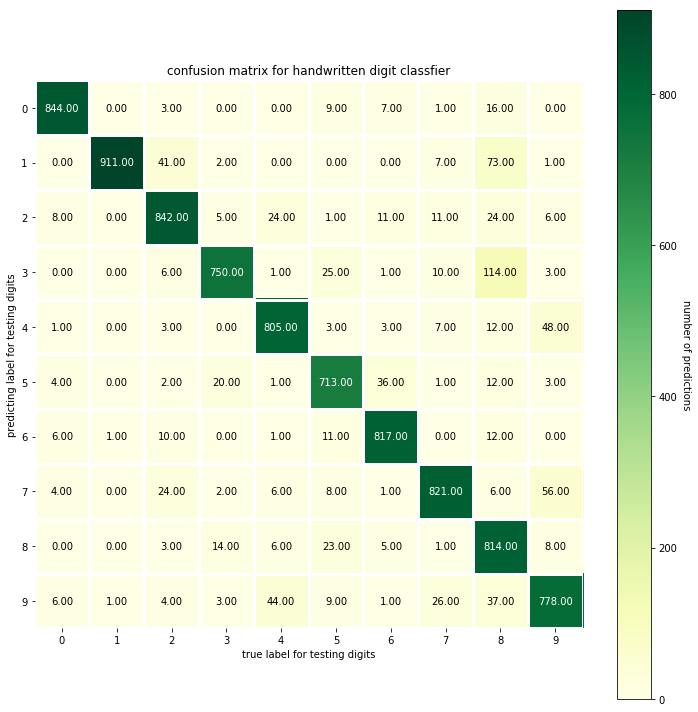

In [7]:
# load data and label
datafile = np.load('digits-labels.npz')
d_data = datafile['d'].T
d_label = datafile['l']

# preprocess data to divide them into training and testing sets
d_train_data = np.zeros((1000,784))
d_train_label = []
d_test_data = []
d_test_label = []
for c in range(10):
    d_train_data[(c*100):(c*100)+100] = d_data[np.where(d_label==c)[0][:100]]
    d_train_label.append(d_label[np.where(d_label==c)[0][:100]])
    d_test_data = np.append(d_test_data, d_data[np.where(d_label==c)[0][100:]])
    d_test_label.append(d_label[np.where(d_label==c)[0][100:]])
d_test_data = d_test_data.reshape((-1, 784))

# generate Gaussians and predict testing dataset
for k in range(1, 784):
    D_GC = Gaussian_clusters(d_train_data, d_train_label, k=k, cluster=10)
    D_GC.find_clusters()
    d_acc, d_confusion_mat = D_GC.predict(d_test_data, d_test_label)
    if np.mean(d_acc) >= 0.9:
        ave_acc = np.mean(d_acc)
        print('The minimum dimension reduction by PCA needs to be {} for the accuracy higher than 90%'.format(k))
        break
for i in range(10):
    print('The accuracy for digit {} is {:.2f}%'.format(i, d_acc[i]*100))
print('The average accuracy for all digits is {:.2f}%'.format(ave_acc*100))

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
true_label = pred_label = [str(i) for i in range(10)]
im, cbar = heatmap(d_confusion_mat, true_label, pred_label, ax=ax, cmap="YlGn", cbarlabel="number of predictions")
texts = annotate_heatmap(im)
fig.tight_layout()
plt.title('confusion matrix for handwritten digit classfier')
plt.xlabel('true label for testing digits')
plt.ylabel('predicting label for testing digits')
plt.show()

As the above result shows, for the accuracy to beat the 90% baseline, the dimensionality reduction performed by PCA can not be lower than 17 dimensions. It can be seen that Gaussian does a good job in classifying the data at the low-dimensional space, and the algorithm is actually quite simple. Also, as we expect, the classfier has problem in classifying some data sharing similar features. For example, 3 and 8 are written in a similar manner, so the classfier misclassfies a lot of 3's as 8's.

## Problem 3 Speech / No Speech classifier
In this problem, we can use the technique we apply to problem 2 to build a classifier. However, We need some further processing since now we are dealing with 2D data(spectrograms). To compensate this, we can first concatenate all the spectrograms into one big spectrogram. We can give label to each column, or time frame, and find the corresponding Gaussians. In the testing state, we can treat each column(frequency coefficients at each time frame) as one data and determine whether it belongs to speech or music. An audio data is classified as speech if most time frames are classified as speech and as music vice versa.

In [8]:
import os
from scipy.io.wavfile import read
from scipy import signal

The accuracy for speech data is {}% 100.0
The accuracy for music data is {}% 100.0


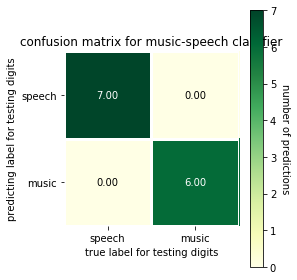

In [9]:
# define some hyperparameters
window = 'hamming'
nperseg = 441
noverlap = 0

# read data and load their log spectrograms into corresponding dataset
sm_paths = ['SpeechMusic/speech', 'SpeechMusic/music']
sm_data = [[],[]]
for p,d in zip(sm_paths, sm_data):
    for f in os.listdir(p):
        abs_f = os.path.join(p, f)
        fs, wav = read(abs_f)
        _, _, X = signal.stft(x=wav, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
        X = np.log(np.abs(X)+1e-6)
        d.append(X)
        
# further process the data so that we have ono-to-one mapping between data and label for training and testing
s_train_perc = int(len(sm_data[0]) * 0.9)
m_train_perc = int(len(sm_data[1]) * 0.9)
temp_data = [sm_data[0][:s_train_perc], sm_data[1][:m_train_perc]]
sm_train_data = [[],[]]
sm_train_label = [[],[]]
for i, ds in enumerate(temp_data):
    for d in ds:
        if len(sm_train_data[i])==0:
            sm_train_data[i] = d
        else:
            sm_train_data[i] = np.concatenate((sm_train_data[i], d), axis=1)
    sm_train_label[i] = i*np.ones(sm_train_data[i].shape[1])
sm_train_data = np.concatenate((sm_train_data[0], sm_train_data[1]), axis=1)
sm_test_data = [sm_data[0][s_train_perc:], sm_data[1][m_train_perc:]]

# generate Gaussians and predict testing dataset
SM_GC = Gaussian_clusters(sm_train_data.T, sm_train_label, k=30, cluster=2)
SM_GC.find_clusters()
sm_acc = [0,0]
sm_confusion_mat = np.zeros((2,2))
for i, tds in enumerate(sm_test_data):
    for t in tds:
        if i==0:
            t_label = [i * np.ones(t.shape[0]),[]]
        else:
            t_label = [[], i * np.ones(t.shape[0])]
        t_acc, _ = SM_GC.predict(t.T, t_label)
        if t_acc[i] > 0.5:
            sm_acc[i] += 1
            sm_confusion_mat[i,i] += 1
        else:
            sm_acc[i] -= 1
            sm_confusion_mat[i, abs(i-1)] += 1
    sm_acc[i] /= len(tds)
print('The accuracy for speech data is {}%',sm_acc[0]*100)
print('The accuracy for music data is {}%',sm_acc[1]*100)
# plot confusion matrix
fig3, ax3 = plt.subplots(figsize=(4,4))
sm_true_label = sm_pred_label = ['speech', 'music']
im3, cbar3 = heatmap(sm_confusion_mat, sm_true_label, sm_pred_label, ax=ax3, cmap="YlGn", cbarlabel="number of predictions")
texts3 = annotate_heatmap(im3)
fig3.tight_layout()
plt.title('confusion matrix for music-speech classfier')
plt.xlabel('true label for testing digits')
plt.ylabel('predicting label for testing digits')
plt.show()

From the result, we can see that the classfier does a good job(100% accuracy) in classfiying the testing data. It is a much simpler classifier compared to complex algorithms such as neural networks, but still achieve very amaizng result.

## Problem 4 A Pool Detector
For this problem, we can still use Gaussian classifier. The tricky part is now that we have to first manually find the training dataset with naked eyes and use the very limited data to classify pools on the testing image. Also, we need to make sure each data has the same size for the training purpose. Here, we force each training data to have size of 5-by-5 pixels and apply the classfier on each 5-by-5 block on the testing image

In [10]:
import matplotlib.image as mpimg 

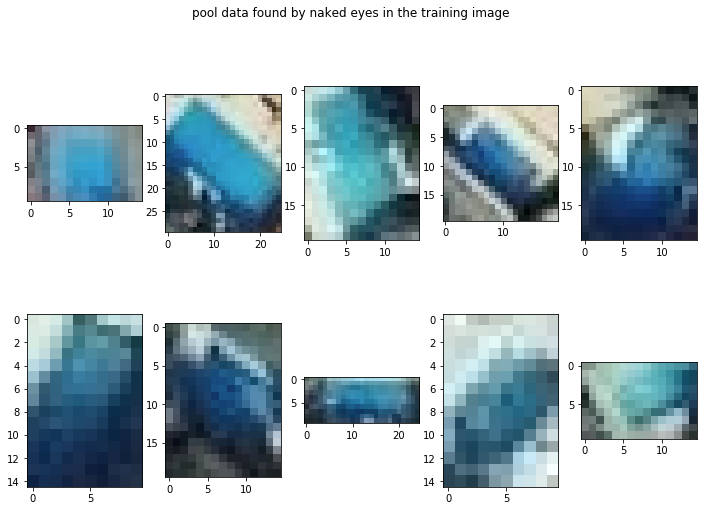

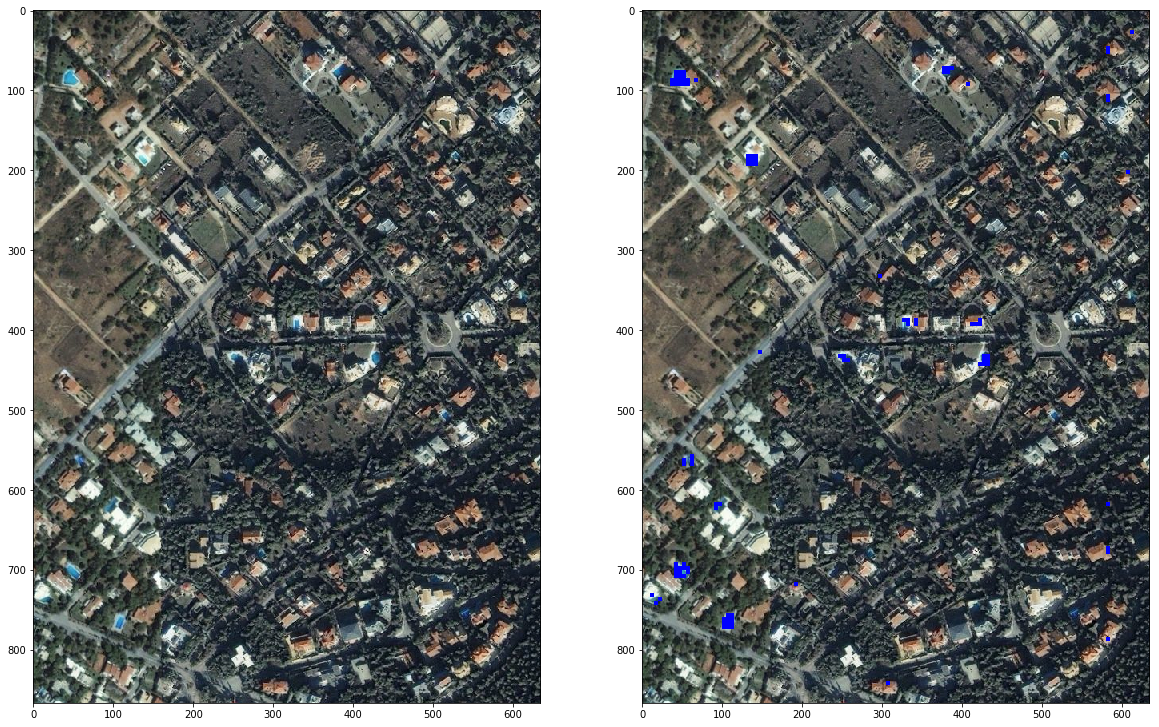

In [12]:
# load images
train_img = mpimg.imread('ekalismall.png')
test_img = mpimg.imread('ekalismall2.png')

# display training data found by naked eyes
raw_train_data = []
idxs = np.array([[270, 280, 200, 215], [160, 190, 440, 465], [200, 220, 300,315], [140, 160, 635,655], \
       [200, 220,665, 680], [425,440,560,570], [455,475,765,780], [670,680, 70,95],\
        [580,595,395,405], [605,615,430,445]])
plt.figure(figsize=(12,8))
plt.suptitle('pool data found by naked eyes in the training image')
for i, idx in enumerate(idxs):
    r_min = idx[0]
    r_max = idx[1]
    c_min = idx[2]
    c_max = idx[3]
    d = train_img[r_min:r_max, c_min:c_max, :]
    raw_train_data.append(d)
    plt.subplot(2, len(idxs)/2, i+1)
    plt.imshow(d)
    
# get the top-left index for each 5-by-5 pool data
pool_top_idx = []
for idx in idxs:
    for i in range(idx[0], idx[1], 5):
        for j in range(idx[2], idx[3], 5):
            pool_top_idx.append([i,j])

# process data to get training data and label
row,col,_ = train_img.shape
im_train_data = [[],[]]
for r in range(0, row//5*5-5, 5):
    for c in range(0, col//5*5-5, 5):
        img = train_img[r:r+5, c:c+5]
        if [r,c] in pool_top_idx:
            im_train_data[0].append(img)
        else:
            im_train_data[1].append(img)
pool = np.array(im_train_data[0])
non_pool = np.array(im_train_data[1])
im_train_data = np.concatenate((pool, non_pool), axis=0)
im_train_data = im_train_data.reshape((-1, 100))
im_train_label = [np.zeros(len(pool)), np.ones(len(non_pool))]
N = len(pool) + len(non_pool)
im_prior = [len(pool)/N, len(non_pool)/N]

# generate gaussians
P_GC = Gaussian_clusters(im_train_data, im_train_label, k=75, cluster=2)
P_GC.find_clusters()

# process data to get testing data
row,col,_ = test_img.shape
r_grid = row//5*5-5
c_grid = col//5*5-5
im_test_data = []
for r in range(0, r_grid, 5):
    for c in range(0, c_grid, 5):
        img = test_img[r:r+5, c:c+5]
        im_test_data.append(img)
im_test_data = np.array(im_test_data)
im_test_data = im_test_data.reshape((-1, 100))
im_test_pca = (P_GC.w_pca @ (im_test_data - P_GC.x_mean).T).T

# compute Gaussian statistics
pool_mean, non_pool_mean = P_GC.means
pool_cov, non_pool_cov = P_GC.covs
is_pool = []
pool_prob = im_prior[0]*MN(im_test_pca, pool_mean, pool_cov)
non_pool_prob = im_prior[1]*MN(im_test_pca, non_pool_mean, non_pool_cov)

# predict whether a 5-by-5 area is a pool
is_pool = np.zeros(len(im_test_pca))
is_pool[np.where(pool_prob > non_pool_prob)[0]] = 1
is_pool = is_pool.reshape(int(r_grid/5), int(c_grid/5))
pred_img = test_img.copy()
for r in range(0, r_grid, 5):
    for c in range(0, c_grid, 5):
        if (is_pool[int(r/5), int(c/5)] == 1):
            pred_img[r:r+5, c:c+5] = [0,0,1.0,1.0]

# plot the result
plt.figure(figsize=(20,25))
plt.subplot(121)
plt.imshow(test_img)
plt.subplot(122)
plt.imshow(pred_img)

For this problem, we use 75 PCA dimensions and result is shown as the right image above. It can be seen the classifier does a good job in detecting the pool.